# Luther - Linear Regression Model

This is where I work with the merged dataframe to fit a linear regression model in order to predict the opening box office gross

In [1]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from scipy.stats import boxcox
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings
warnings.filterwarnings('ignore')

/Users/petermin/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/petermin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Import merged dataframe
merged_df = pd.read_pickle('data/merged_df.pkl')
merged_df.head(7)

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,year,Yviews_adj,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,2013,5649515.0,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,2013,4249150.0,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,2013,8467428.0,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,2013,454111.0,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,2013,382762.0,514.0,44.0,47.0,8.13,4458.3,81,843.5,10
5,Ender's Game,Ender's Game,27017351,3323167,2013-11-01,3407,61737191,6.9,6.7,51,...,2013,1673684.0,4379.0,288.0,1414.0,8.13,4902.1,52,0.0,0
6,Free Birds,Free Birds,15805237,1944063,2013-11-01,3736,55750480,6.9,5.9,38,...,2013,386277.0,945.0,77.0,130.0,8.13,2996.1,56,165.0,3


In [3]:
# add these columns to account for whether the actors/directors were identified
merged_df["dirgross_bin"] = merged_df.dir_gross.apply(lambda x: x/x if x > 0 else x)
merged_df["actgross_bin"] = merged_df.act_gross.apply(lambda x: x/x if x > 0 else x)
merged_df.head()

,movie_name,movie,op_gross,est_tick,date_time,theaters,tot_gross,unemp_rate,imdb,metacritic,...,Ylikes_adj,Ydis_adj,Ycom_adj,tick,act_gross,act_nmovies,dir_gross,dir_nmovies,dirgross_bin,actgross_bin
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,424668047,6.9,7.5,76,...,23726.0,632.0,4329.0,8.13,3333.4,56,1056.5,7,1.0,1.0
1,Frozen,Frozen,243390,29937,2013-11-22,1,400738009,6.9,7.5,74,...,6715.0,1074.0,925.0,8.13,1774.2,19,230.0,3,1.0,1.0
2,Thor: The Dark World,Thor: The Dark World,85737841,10545859,2013-11-08,3841,206362140,6.9,7.0,54,...,30885.0,1178.0,5576.0,8.13,2968.6,57,89.7,2,1.0,1.0
3,The Best Man Holiday,The Best Man Holiday,30107555,3703266,2013-11-15,2024,70525195,6.9,6.7,59,...,1194.0,72.0,172.0,8.13,1328.5,34,346.3,9,1.0,1.0
4,Last Vegas,Last Vegas,16334566,2009171,2013-11-01,3065,63914167,6.9,6.6,48,...,514.0,44.0,47.0,8.13,4458.3,81,843.5,10,1.0,1.0


In [4]:
#Split test and train. Predict 2017 movies based on training from 2013-2016
merged_test = merged_df[merged_df.year == 2017]
merged_train = merged_df[merged_df.year != 2017]
merged_2017 = merged_df[merged_df.year == 2017]

In [5]:
#merged2.columns
#drop unnecessary/duplicate columns
merged_test = merged_test.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)
merged_train = merged_train.drop(["movie","movie_name","tick", "year",
                        "tot_gross","op_gross","date_time"],1)


In [6]:
X_train = patsy.dmatrix('rated',data=merged_train,return_type='dataframe')
X_test = patsy.dmatrix('rated',data=merged_test,return_type='dataframe')
X_train.head()

,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,1.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0


In [7]:
merged2_test = merged_test.join(X_test)
merged2_test = merged_test.drop(["rated"],1)
merged2_train = merged_train.join(X_train)
merged2_train = merged_train.drop(["rated"],1)


In [8]:
#sns.pairplot(merged2)
#sns.regplot(merged2.unemp_rate, merged2.est_tick)
# Add 1 to the comments, director gross and actor gross in order to normalize data with 
# log or boxcox
merged2_test['Ycom_adj'] = merged2_test.Ycom_adj.apply(lambda x: x + 1)
merged2_test['dir_gross'] = merged2_test.dir_gross.apply(lambda x: x + 1)
merged2_test['act_gross'] = merged2_test.act_gross.apply(lambda x: x + 1)
merged2_test['act_nmovies'] = merged2_test.act_gross.apply(lambda x: x + 1)
merged2_test['dir_nmovies'] = merged2_test.act_gross.apply(lambda x: x + 1)

merged2_train['Ycom_adj'] = merged2_train.Ycom_adj.apply(lambda x: x + 1)
merged2_train['dir_gross'] = merged2_train.dir_gross.apply(lambda x: x + 1)
merged2_train['act_gross'] = merged2_train.act_gross.apply(lambda x: x + 1)
merged2_train['act_nmovies'] = merged2_train.act_gross.apply(lambda x: x + 1)
merged2_train['dir_nmovies'] = merged2_train.act_gross.apply(lambda x: x + 1)

In [9]:
# Normalize dataset with log transformation
merged2_train["tick_log"] = np.log(merged2_train.est_tick)
merged2_train["Ylikes_log"] = np.log(merged2_train.Ylikes_adj)
merged2_train["Yviews_log"] = np.log(merged2_train.Yviews_adj)
merged2_train["Ydis_log"] = np.log(merged2_train.Ydis_adj)
merged2_train["runtime_log"] = np.log(merged2_train.runtime)
merged2_train["dir_gross"] = np.log(merged2_train.dir_gross)
merged2_train["act_gross"] = np.log(merged2_train.act_gross)
merged2_train["Ycom_log"] = np.log(merged2_train.Ycom_adj)
merged3_train = merged2_train.drop(["est_tick","Ylikes_adj","Yviews_adj","Ydis_adj","runtime",
                       "act_gross","dir_gross","Ycom_adj"], 1)

merged2_test["tick_log"] = np.log(merged2_test.est_tick)
merged2_test["Ylikes_log"] = np.log(merged2_test.Ylikes_adj)
merged2_test["Yviews_log"] = np.log(merged2_test.Yviews_adj)
merged2_test["Ydis_log"] = np.log(merged2_test.Ydis_adj)
merged2_test["runtime_log"] = np.log(merged2_test.runtime)
merged2_test["dir_gross"] = np.log(merged2_test.dir_gross)
merged2_test["act_gross"] = np.log(merged2_test.act_gross)
merged2_test["Ycom_log"] = np.log(merged2_test.Ycom_adj)
merged3_test = merged2_test.drop(["est_tick","Ylikes_adj","Yviews_adj","Ydis_adj","runtime",
                       "act_gross","dir_gross","Ycom_adj"], 1)

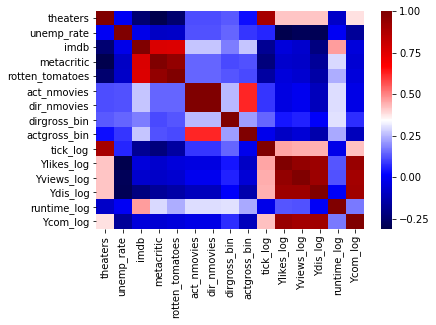

In [10]:
sns.heatmap(merged3_train.corr(), cmap = "seismic")

In [11]:
merged3_train.columns

Index(['theaters', 'unemp_rate', 'imdb', 'metacritic', 'rotten_tomatoes',
       'act_nmovies', 'dir_nmovies', 'dirgross_bin', 'actgross_bin',
       'tick_log', 'Ylikes_log', 'Yviews_log', 'Ydis_log', 'runtime_log',
       'Ycom_log'],
      dtype='object')

In [12]:
y_train = merged3_train.tick_log
X_train = merged3_train.drop(['tick_log'],1)

y_test = merged3_test.tick_log
X_test = merged3_test.drop(['tick_log'],1)
#model= LinearRegression()
#fit = model.fit(X,y)

In [14]:
# Split CV. Note that the training set (2013-2016) is being divided into
# X_trainCV and X_CV <- which is for the validation set
X_trainCV, X_CV, y_trainCV, y_CV = train_test_split(X_train,y_train,test_size = 0.3,
                                                   random_state= 42)

In [16]:
# Linear model without polyfit
alphas = [0,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
l1 = [0, 1e-8, 1e-6, 1e-4, 1e-2, .5, .9, 1]
degree = 2
lin_model = make_pipeline(ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
lin_model.fit(X_trainCV,y_trainCV)
print("alpha =", lin_model.named_steps.elasticnetcv.alpha_)
print("l1_ratio =", lin_model.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", lin_model.score(X_CV,y_CV))

alpha = 0.1
l1_ratio = 0.0
R^2 on CV = 0.8221842293192617


In [17]:
# Polyfit model with elastic net
alphas = [1e-4,1e-3,1e-2,1e-1,1,10,30,60,90,100,300,600]
l1 = [0, .1, .5, .7, .9, .95, .99, 1]
degree = 2
poly_model = make_pipeline(PolynomialFeatures(degree),
                    ElasticNetCV(alphas=alphas, l1_ratio = l1,cv=10))
poly_model.fit(X_trainCV,y_trainCV)
print("alpha =", poly_model.named_steps.elasticnetcv.alpha_)
print("l1_ratio =", poly_model.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", poly_model.score(X_CV,y_CV))

alpha = 60.0
l1_ratio = 1.0
R^2 on CV = 0.8481035872061926


In [18]:
# Polyfit model with lasso
alphas = [1e-4,1e-3,1e-2,1e-1,1,10,30,60,90,100,300,600]
l1 = [0, .1, .5, .7, .9, .95, .99, 1]
degree = 2
poly_model_lasso = make_pipeline(PolynomialFeatures(degree),
                    LassoCV(alphas=alphas,cv=10))
poly_model_lasso.fit(X_trainCV,y_trainCV)
print("alpha =", poly_model_lasso.named_steps.lassocv.alpha_)
#print("l1_ratio =", poly_model_lasso.named_steps.elasticnetcv.l1_ratio_)
print("R^2 on CV =", poly_model_lasso.score(X_CV,y_CV))

alpha = 60.0
R^2 on CV = 0.8481035872061926


In [19]:
import math
from sklearn.metrics import mean_squared_error
rms = math.exp(math.sqrt(mean_squared_error(y_test, poly_model.predict(X_test))))
r_squared = poly_model.score(X_test,y_test)
print("R^2 =", r_squared)
print("rms =", rms)

#poly_model.predict(X_CV)

R^2 = 0.868917987425063
rms = 1.8807742968215904


In [28]:
import scipy.stats as stats
def diagnostic_plot(x, y, model):
    plt.figure(figsize=(20,5))
    pred = model.predict(x)
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    

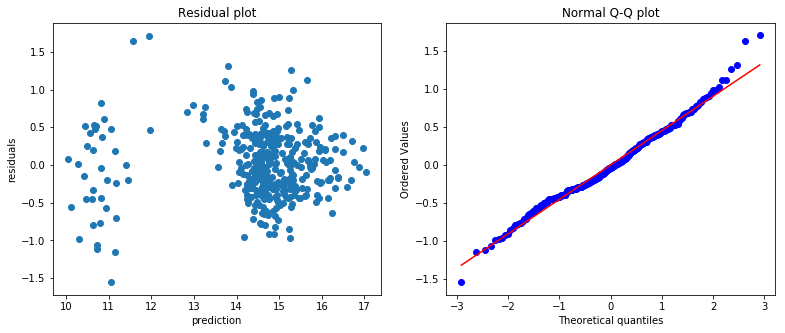

In [29]:
diagnostic_plot(X_train, y_train, poly_model)

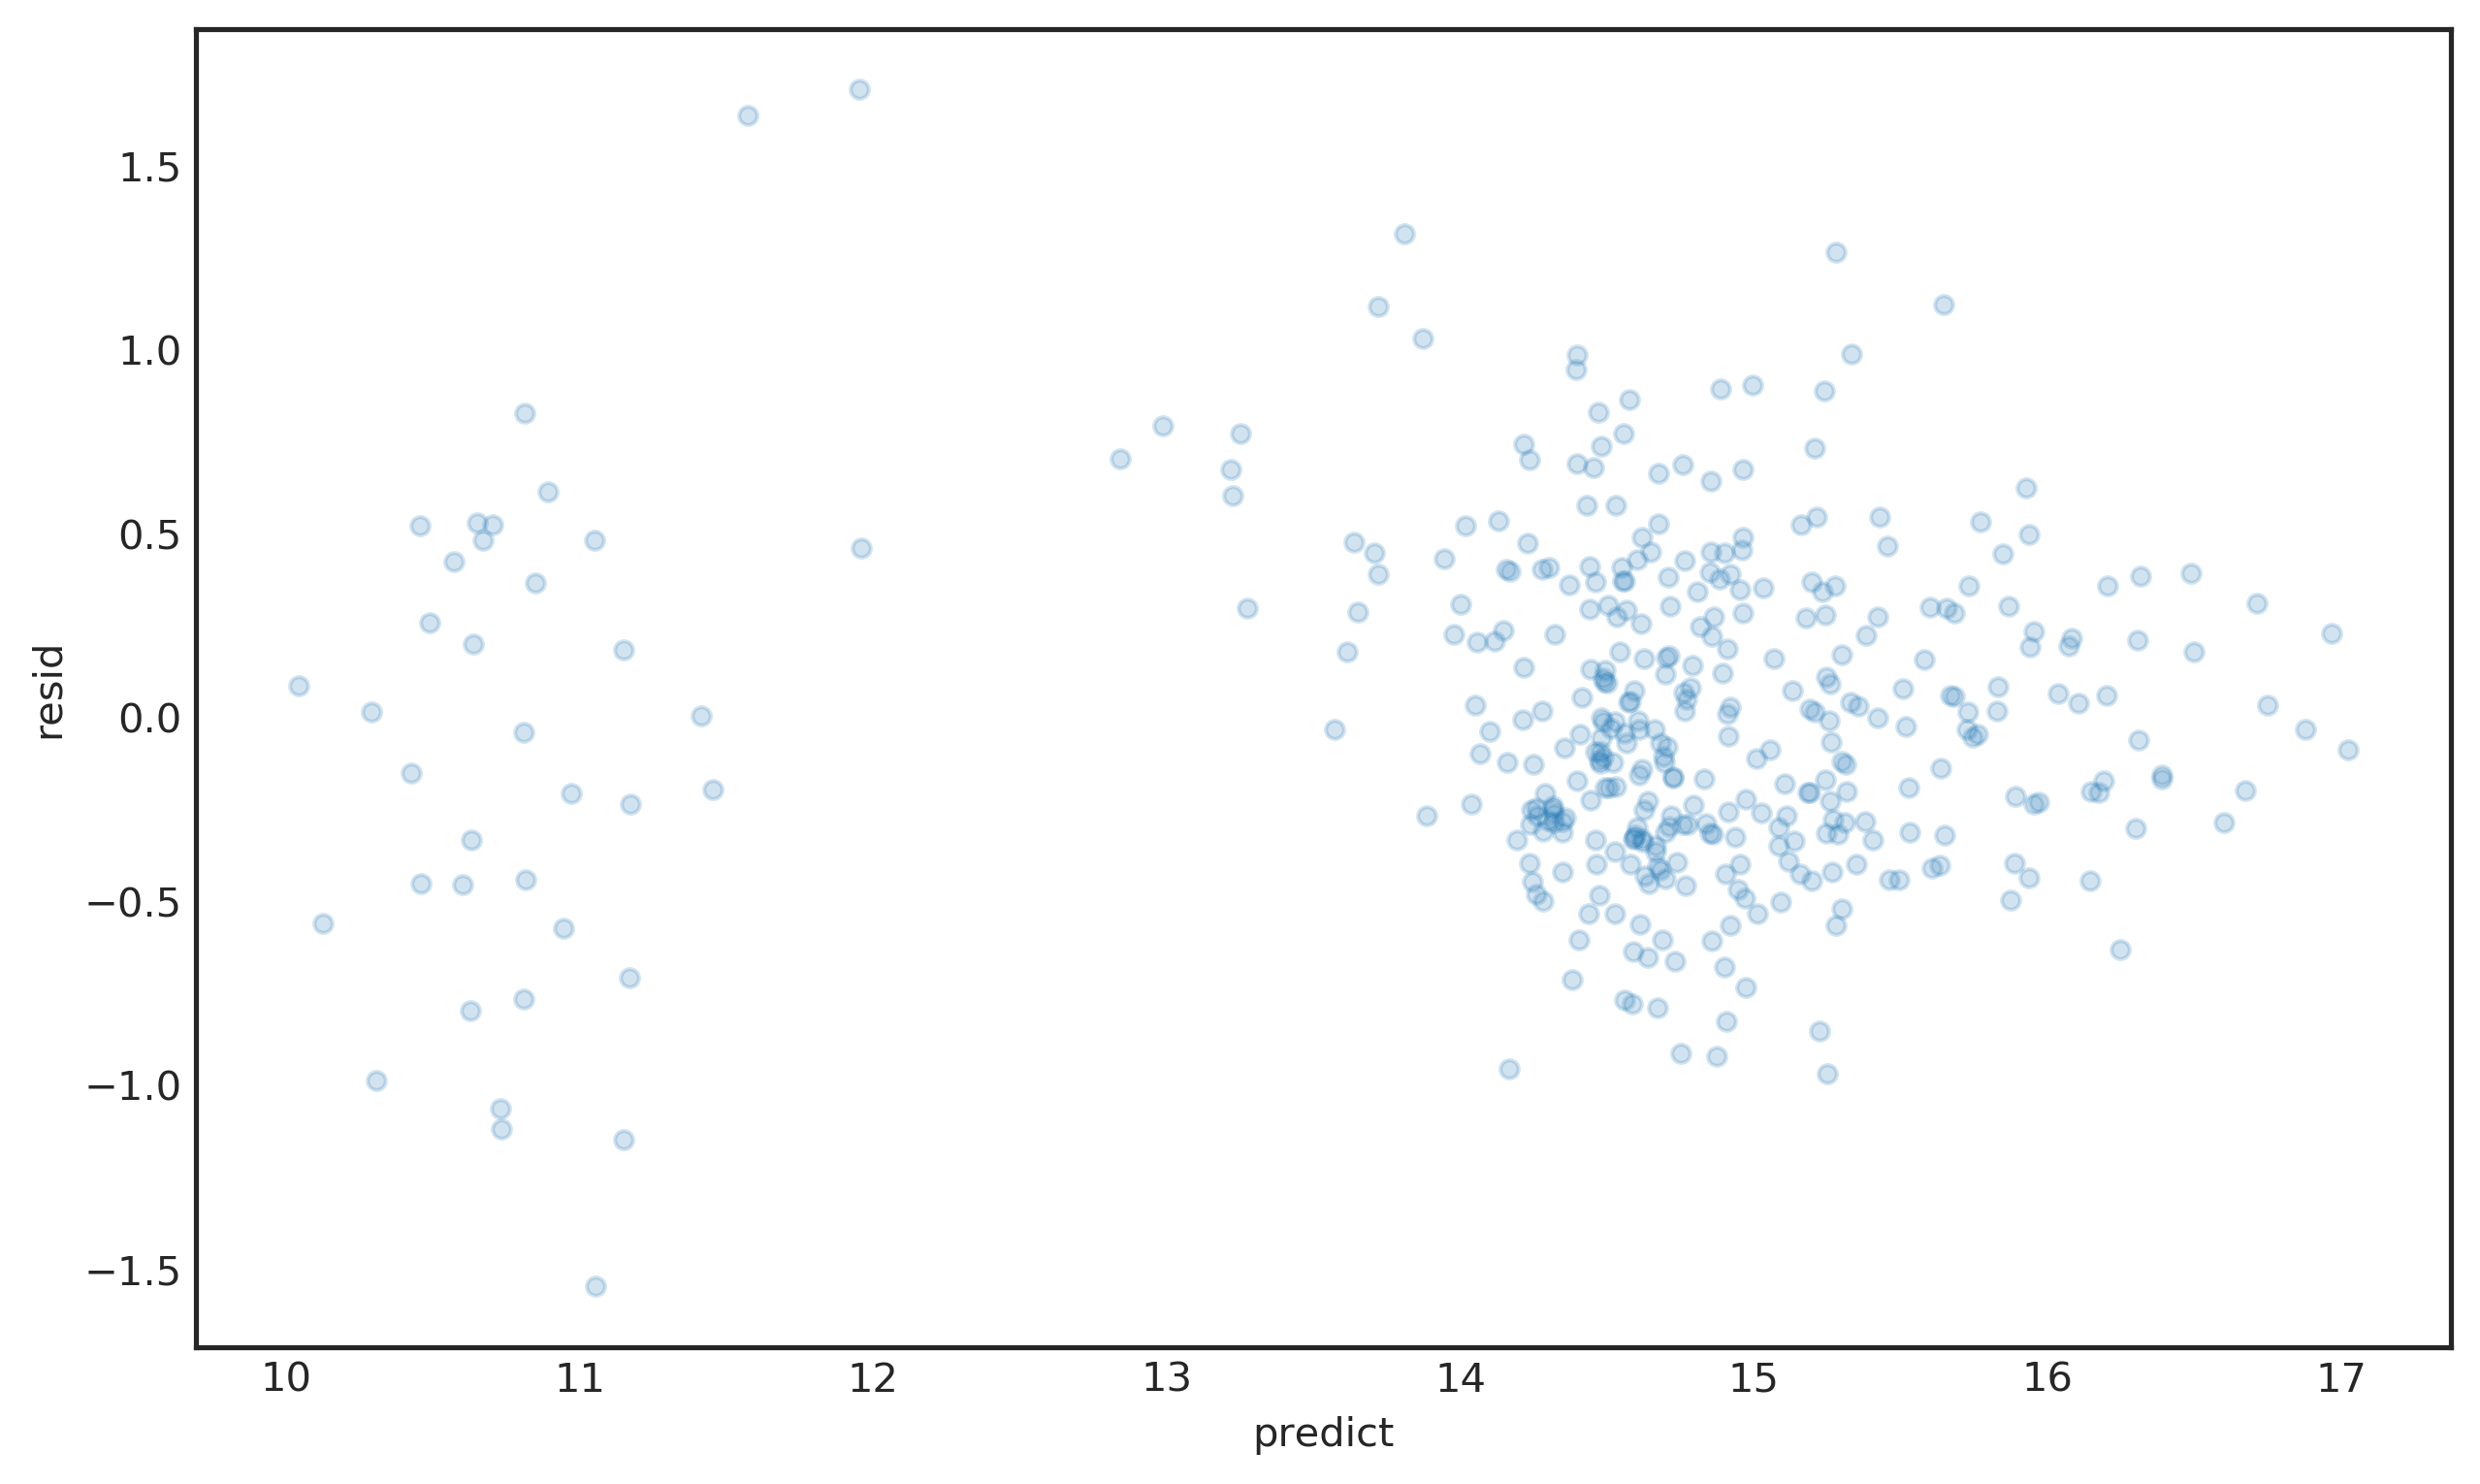

In [729]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
merged4 = merged3_train
merged4['predict']=poly_model.predict(X_train)
merged4['resid']=merged3_train.tick_log-merged4_train.predict
with sns.axes_style('white'):
    plot=merged4.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))


## See how well the linear regression performs on 2017 data

In [730]:
prediction = poly_model.predict(X_test)

In [731]:
math.exp(16.854)

20873688.492063176

In [732]:
merged_2017 = merged_2017.drop(["movie","date_time","theaters","unemp_rate",
                                 "imdb","metacritic","Ycom_adj","Ylikes_adj",
                                 "Ydis_adj","rotten_tomatoes","runtime",
                                 "dir_nmovies","dirgross_bin","actgross_bin",
                                 "dir_gross","act_gross","act_nmovies"],1)
merged_2017["predict_tick"] = prediction
merged_2017["predict_tick"] = merged_2017.predict_tick.apply(lambda x: math.exp(x))
merged_2017["predict_gross"] = merged_2017.predict_tick.multiply(merged_2017.tick)
merged_2017["predict_gross_error"] = merged_2017.op_gross.subtract(merged_2017.predict_gross)
merged_2017["predict_tick_error"] = merged_2017.est_tick.subtract(merged_2017.predict_tick)
merged_2017["percent_gross_error"] = merged_2017.predict_gross_error.divide(
    merged_2017.op_gross)
merged_2017["percent_gross_error"] = merged_2017.percent_gross_error.apply(lambda x: abs(x))
merged_2017.head()

,movie_name,op_gross,est_tick,tot_gross,rated,year,Yviews_adj,tick,predict_tick,predict_gross,predict_gross_error,predict_tick_error,percent_gross_error
382,Star Wars: The Last Jedi,220009584,24527266,620181382,PG-13,2017,40390750.000,8.970,32008028.554,287112016.133,-67102432.133,-7480762.554,0.305
383,Jumanji: Welcome to the Jungle,36169328,4032255,404134301,PG-13,2017,10599494.000,8.970,4772866.135,42812609.231,-6643281.231,-740611.135,0.184
384,The Greatest Showman,8805843,981699,173524478,PG,2017,2932465.000,8.970,1533515.452,13755633.600,-4949790.600,-551816.452,0.562
385,Pitch Perfect 3,19928525,2221686,104897530,PG-13,2017,7204821.000,8.970,3073197.217,27566579.035,-7638054.035,-851511.217,0.383
386,Ferdinand,13401586,1494045,84322735,PG,2017,1469967.000,8.970,2634738.653,23633605.718,-10232019.718,-1140693.653,0.763


In [733]:
merged_2017.percent_gross_error.describe()

count   87.000
mean     0.849
std      2.998
min      0.003
25%      0.132
50%      0.326
75%      0.614
max     27.698
Name: percent_gross_error, dtype: float64

0.250   -6985163.297
0.500    -400193.085
0.750    2944282.643
Name: predict_gross_error, dtype: float64


(array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
          60.]), <a list of 10 Text xticklabel objects>)

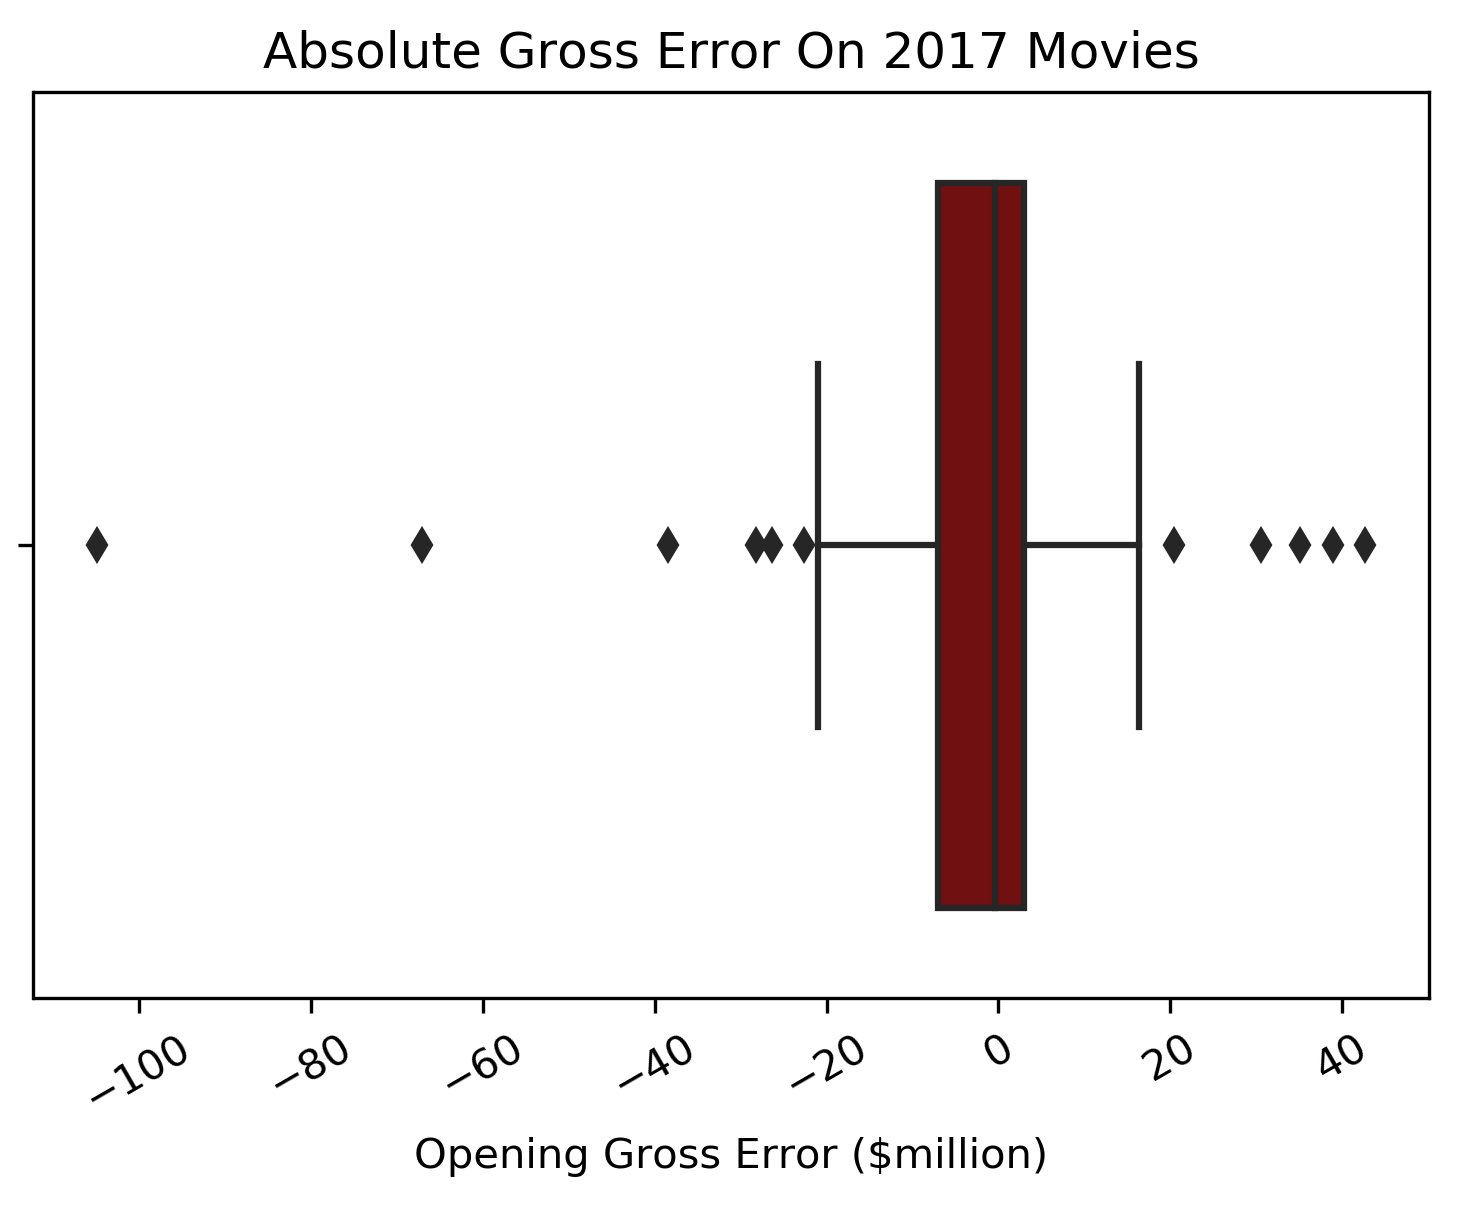

In [734]:
print(merged_2017.predict_gross_error.quantile([0.25,0.5,0.75]))
sns.boxplot(merged_2017.predict_gross_error.apply(lambda x: x/1e6),color="maroon")
#plt.xlim(0, None)
plt.xlabel("Opening Gross Error ($million)")
#plt.xlabel("Actual Gross ($million)")
plt.title("Absolute Gross Error On 2017 Movies")
#plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

0.250   0.132
0.500   0.326
0.750   0.614
Name: percent_gross_error, dtype: float64


(array([  0., 100., 200., 300., 400., 500.]),
 <a list of 6 Text xticklabel objects>)

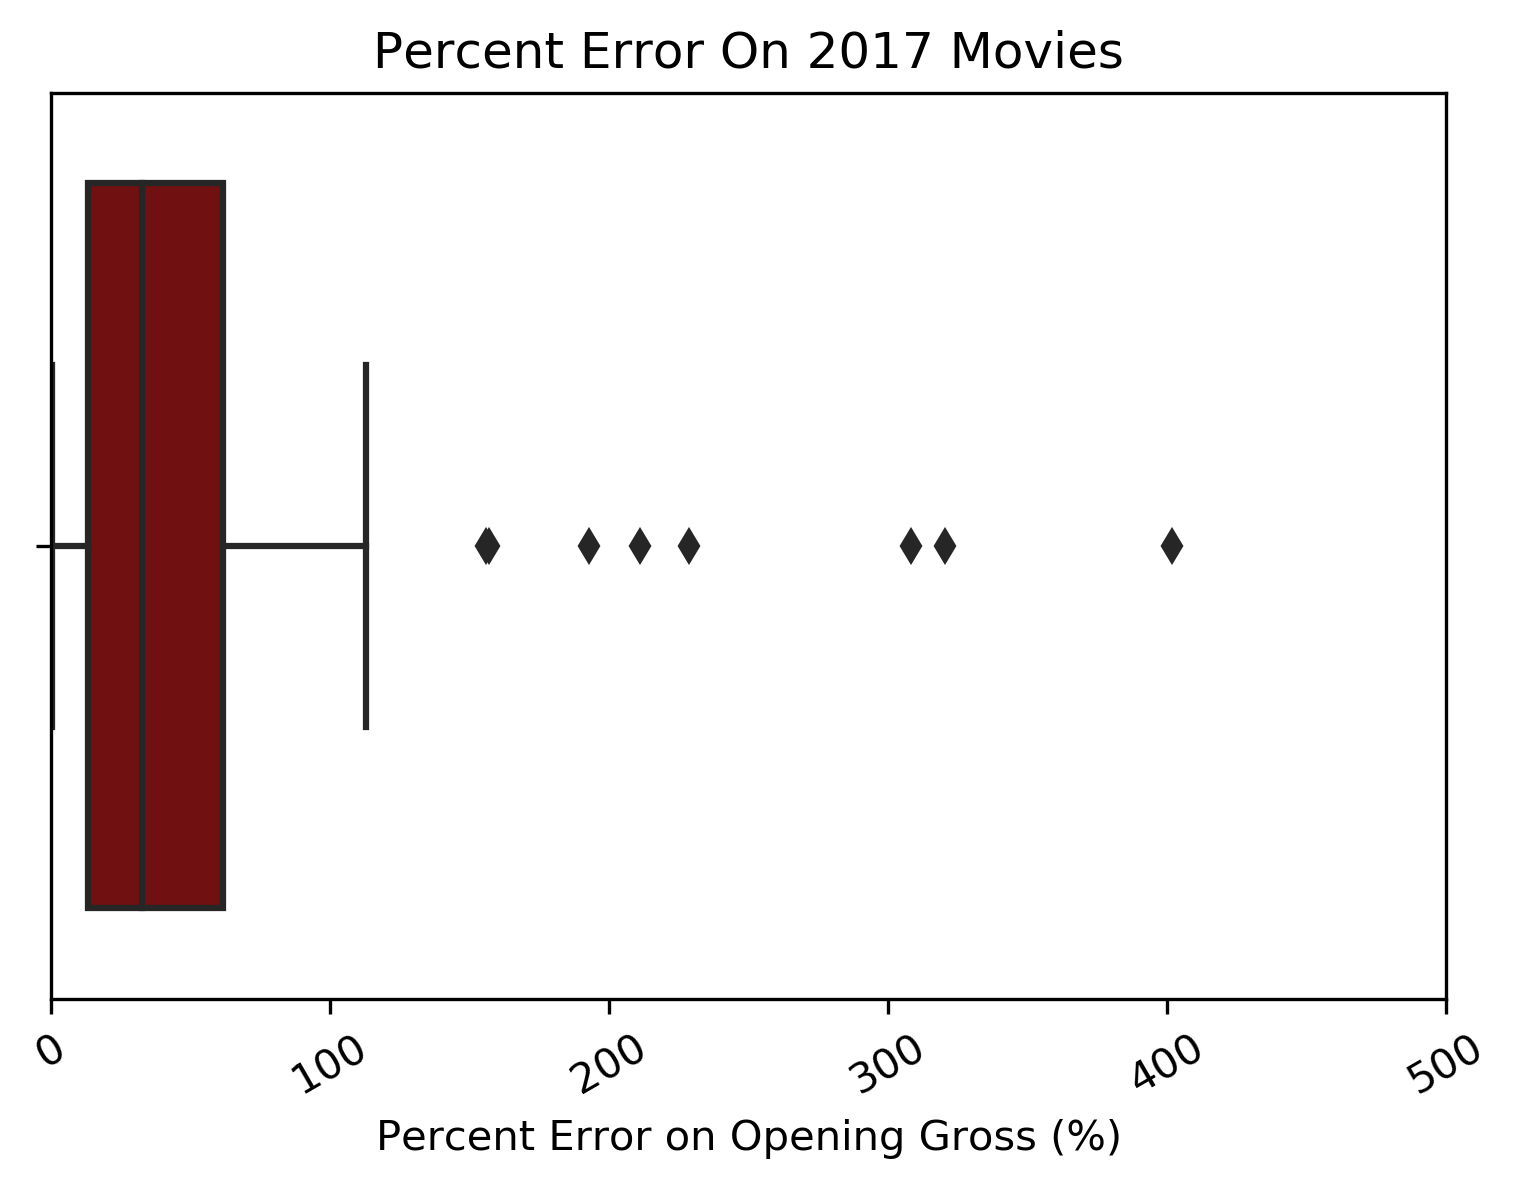

In [735]:
print(merged_2017.percent_gross_error.quantile([0.25,0.5,0.75]))
sns.boxplot(merged_2017.percent_gross_error*100,color="maroon")
plt.xlim(0, 500)
plt.xlabel("Percent Error on Opening Gross (%)")
plt.title("Percent Error On 2017 Movies")
plt.xticks(rotation=30)

(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text xticklabel objects>)

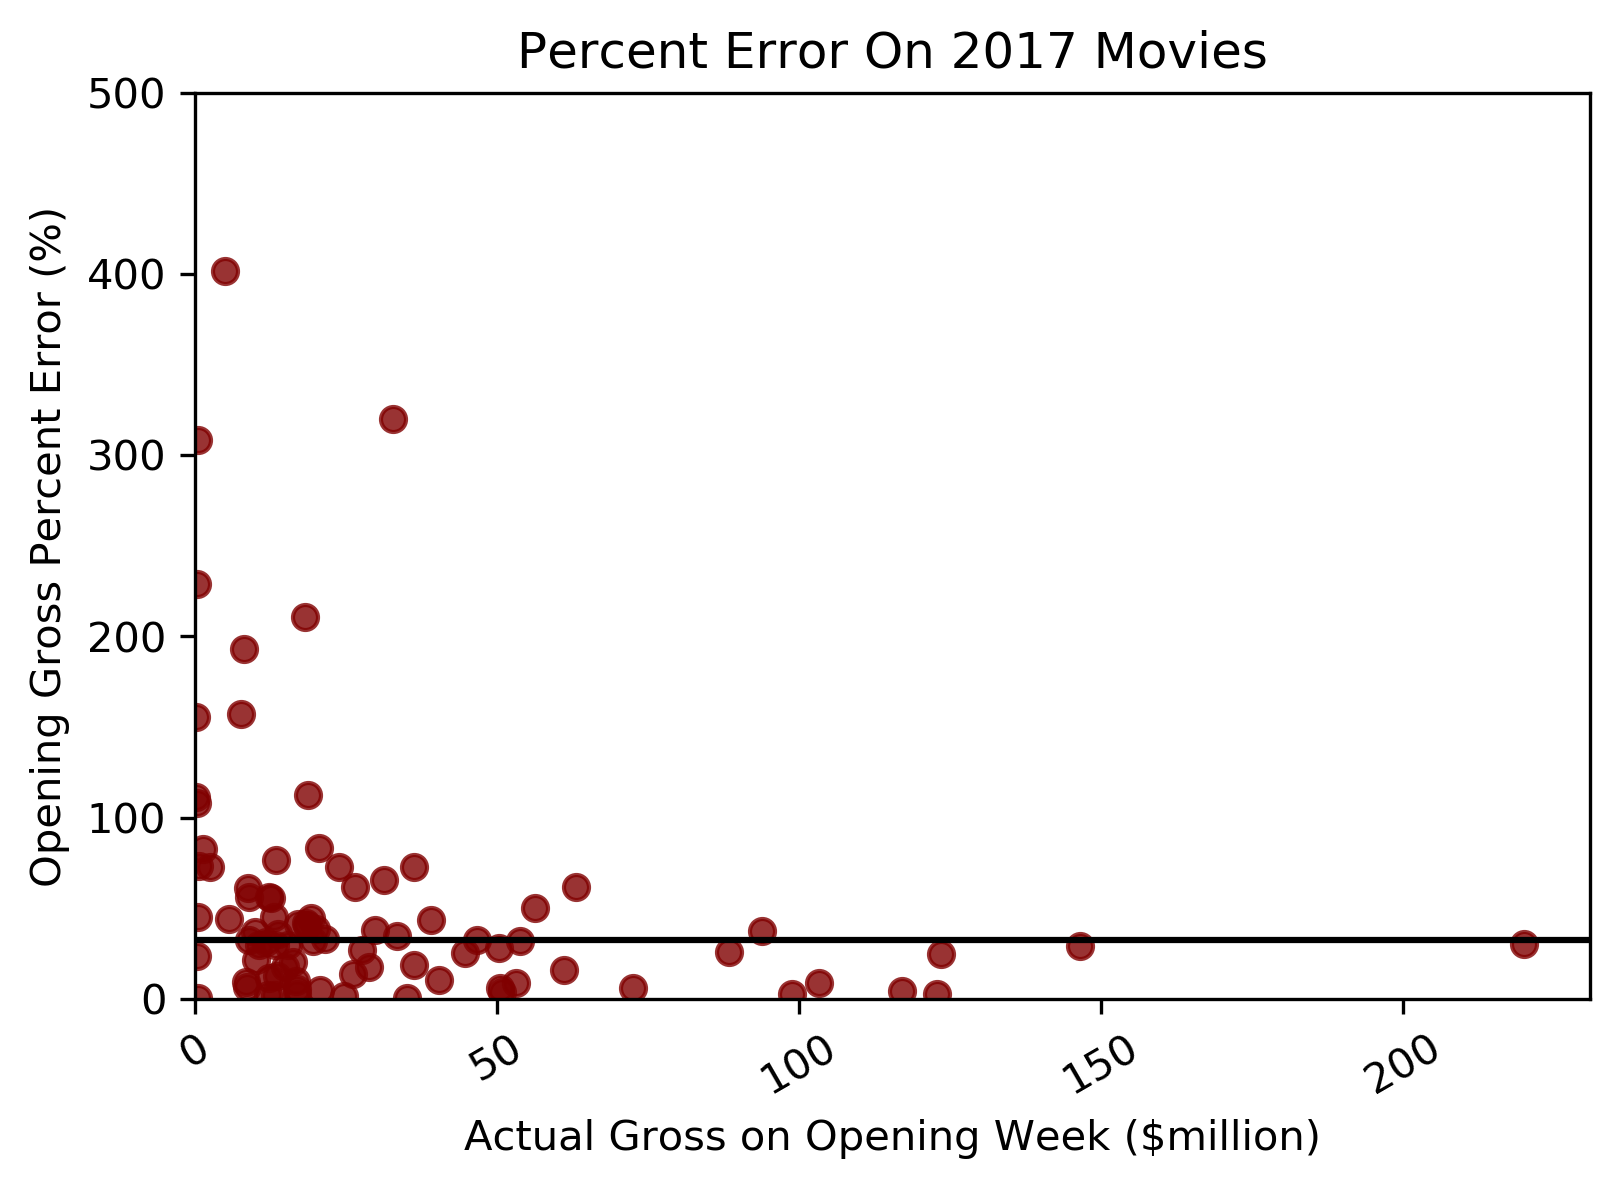

In [736]:
import matplotlib.pyplot as plt
sns.regplot(merged_2017.op_gross/1e6, merged_2017.percent_gross_error*100,fit_reg=False,
           color="maroon")
plt.ylim(0, 500)
plt.xlim(0, None)
plt.plot([0,2e8],[32.6,32.6],'k')
plt.ylabel("Opening Gross Percent Error (%)")
plt.xlabel("Actual Gross on Opening Week ($million)")
plt.title("Percent Error On 2017 Movies")
plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

(array([  0.,  50., 100., 150., 200., 250.]),
 <a list of 6 Text xticklabel objects>)

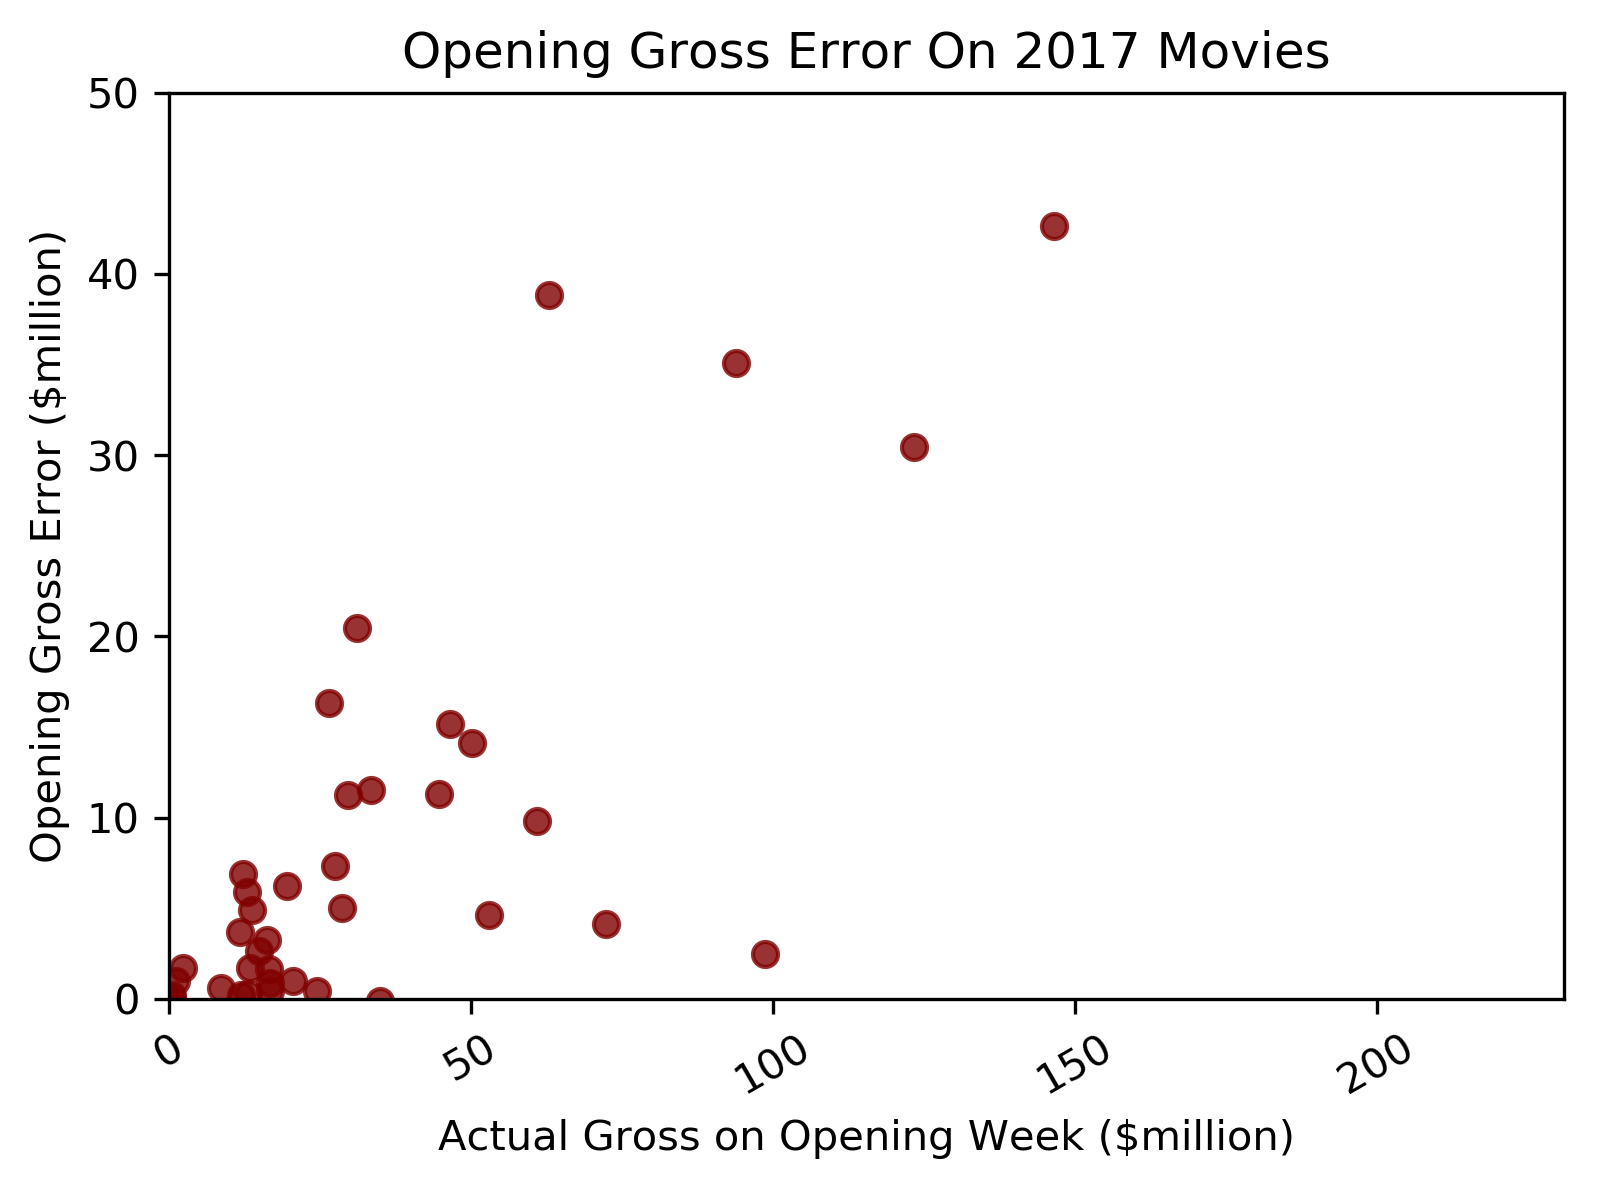

In [742]:
import matplotlib.pyplot as plt
sns.regplot(merged_2017.op_gross/1e6, merged_2017.predict_gross_error/1e6,fit_reg=False,
            color="maroon")
plt.ylim(0, None)
plt.xlim(0, None)
plt.ylabel("Opening Gross Error ($million)")
plt.xlabel("Actual Gross on Opening Week ($million)")
plt.title("Opening Gross Error On 2017 Movies")
plt.ticklabel_format(style='plain')
plt.xticks(rotation=30)

In [743]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
merged_2017.sort_values(by="percent_gross_error",ascending=False).head()

,movie_name,op_gross,est_tick,tot_gross,rated,year,Yviews_adj,tick,predict_tick,predict_gross,predict_gross_error,predict_tick_error,percent_gross_error
390,Hostiles,22849,2547,29814750,R,2017,410062.000,8.970,73100.791,655714.092,-632865.092,-70553.791,27.698
393,Downsizing,4954287,552317,24449754,R,2017,4195320.000,8.970,2771330.628,24858835.737,-19904548.737,-2219013.628,4.018
462,Blade Runner 2049,32753122,3651407,92054159,R,2017,11060894.000,8.970,15341635.088,137614466.736,-104861344.736,-11690228.088,3.202
441,Lady Bird,364437,40628,48958273,R,2017,504319.000,8.970,165863.443,1487795.080,-1123358.080,-125235.443,3.082
439,Darkest Hour,175006,19510,56443120,PG-13,2017,446287.000,8.970,64124.759,575199.085,-400193.085,-44614.759,2.287


In [744]:
merged4_train.columns

Index(['theaters', 'unemp_rate', 'imdb', 'metacritic', 'rotten_tomatoes',
       'act_nmovies', 'dir_nmovies', 'dirgross_bin', 'actgross_bin',
       'tick_log', 'Ylikes_log', 'Yviews_log', 'Ydis_log', 'runtime_log',
       'Ycom_log', 'predict', 'resid'],
      dtype='object')

In [746]:
# Check the coefficients for the features in the final model
poly_coeff = pd.DataFrame({"feature" : poly_model.named_steps.polynomialfeatures.get_feature_names(),
              "coefficients" : poly_model.named_steps.elasticnetcv.coef_})
poly_coeff.sort_values(by="coefficients",ascending=False).head(7)
#merged2.iloc[393,:]

,coefficients,feature
68,0.004,x4 x7
62,0.004,x3 x11
44,0.003,x2 x4
31,0.003,x1 x3
61,0.002,x3 x10
73,0.002,x4 x12
74,0.002,x4 x13
